0.0 5.441398092702653
-2.0559685641206602e-20 0.1


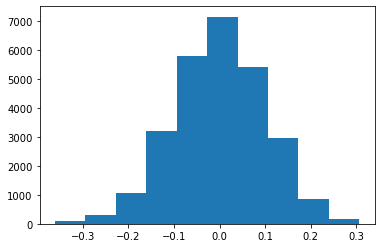

Lossy conversion from float64 to uint8. Range [-0.10624621431335343, 0.09033873615070664]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.09766623232544047, 0.08419090389310815]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.08046855517677498, 0.07030766893364504]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056786692383456405, 0.050566999151148796]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.04532314666450474, 0.04576262785356138]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.056111043711767256, 0.05256762384698538]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.06757343078

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.fft import fftn, ifftn
import imageio

def k_vector(npoints):
    k1 = np.arange(npoints/2+1)
    k2 = np.arange(-npoints/2+1, 0)
    
    kvector = 2*np.pi/ npoints* np.concatenate([k1, k2])
    return kvector

def pk_vector_powerlaw(kvector, n):
    
    npoints = len(kvector)
    shape = [npoints] * dim
    kk = np.zeros(shape)
    
      
    for i, j, k in itertools.product(range(npoints), range(npoints), range(npoints)):
        kk[i, j, k] = np.sqrt(kvector[i]**2 + kvector[j]**2 + kvector[k]**2)
               
    print(np.min(kk),np.max(kk))
    
    pk=1/np.abs(kk)**n
    
    xx, yy, zz = np.mgrid[0:npoints, 0:npoints, 0:npoints]
    r = np.sqrt((xx-npoints/2)**2 + (yy-npoints/2)**2 + (zz-npoints/2)**2)

    mask = r > npoints/2
    mask2 = r < 0.8 * npoints/2
    pk[mask*mask2]=0
    #pk[mask]=0

    pk[0,0,0] = 0
    
    return pk

def pk_vector_delta(kvector, k0, dk0):
    
    npoints = len(kvector)
    shape = [npoints] * dim
    kk = np.zeros(shape)
    
      
    for i, j, k in itertools.product(range(npoints), range(npoints), range(npoints)):
        kk[i, j, k] = np.sqrt(kvector[i]**2 + kvector[j]**2 + kvector[k]**2)
               
    print(np.min(kk),np.max(kk))
    
    pk=np.zeros_like(kk)
    sel=(kk > k0-dk0/2)*(kk < k0+dk0/2)
    pk[sel]=1
    
    xx, yy, zz = np.mgrid[0:npoints, 0:npoints, 0:npoints]
    r = np.sqrt((xx-npoints/2)**2 + (yy-npoints/2)**2 + (zz-npoints/2)**2)

    mask = r > npoints/2
    mask2 = r < 0.8 * npoints/2
    pk[mask*mask2]=0
    #pk[mask]=0

    pk[0,0,0] = 0
    
    return pk


def field_powerlaw(n, npoints):
    
    k = k_vector(npoints)
    pk = pk_vector_powerlaw(k, n)
    Pk1 = np.zeros_like(pk)
    #Pk1 /= Pk1.sum()
    Pk1 = pk

    field=np.random.randn(npoints, npoints, npoints)
    fft_field=fftn(field)
    
    pspect_field = np.sqrt(Pk1) * fft_field
    new_field = np.real(ifftn(pspect_field))
    
    return new_field

def field_delta(k0, dk0, npoints):
    
    k = k_vector(npoints)
    pk = pk_vector_delta(k, k0, dk0)
    Pk1 = np.zeros_like(pk)
    #Pk1 /= Pk1.sum()
    Pk1 = pk

    field=np.random.randn(npoints, npoints, npoints)
    fft_field=fftn(field)
    
    pspect_field = np.sqrt(Pk1) * fft_field
    new_field = np.real(ifftn(pspect_field))
    
    return new_field


if __name__=='__main__':

    npoints = 30
    dim = 3
    n = 3
    
    #new_field=field_powerlaw(n, npoints)
    new_field=field_delta(0.5, 0.05, npoints)
    
    A=0.1 # fluctuation amplitude standard deviation
    norm_field=new_field/np.std(new_field)*A
    
    print(np.mean(norm_field), np.std(norm_field))
    plt.hist(norm_field.flatten())
    plt.show()
    
    xx, yy, zz = np.mgrid[0:npoints, 0:npoints, 0:npoints]
    r = np.sqrt((xx-npoints/2)**2 + (yy-npoints/2)**2 + (zz-npoints/2)**2)
    
    with imageio.get_writer('./new_field_test_0.5.gif', mode='I') as writer:
        for slice in new_field:
            writer.append_data(slice)    
    
    #with imageio.get_writer('./initial_field2.gif', mode='I') as writer:
    #    for slice in field:
    #        writer.append_data(slice)

#fig=plt.figure()
#ax=fig.add_subplot(111, projection='3d')
#ax.voxels(new_field)
#plt.show()